In [1]:
!git clone https://github.com/ksideks/UCSD.git

fatal: docelowa ścieżka „UCSD” już istnieje i nie jest pustym katalogiem.


In [2]:
!pip install keras-layer-normalization

In [3]:
TestVideoFile = {}
TestVideoFile[1] = range(60,180)
TestVideoFile[2] = range(94,180)
TestVideoFile[3] = range(0,146)
TestVideoFile[4] = range(30,180)
TestVideoFile[5] = range(0,129)
TestVideoFile[6] = range(0,159)
TestVideoFile[7] = range(45,180)
TestVideoFile[8] = range(0,180)
TestVideoFile[9] = range(0,120)
TestVideoFile[10] = range(0,150)
TestVideoFile[11] = range(0,180)
TestVideoFile[12] = range(87,180)


In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

In [5]:
class Config:
  DATASET_PATH ="UCSD_v5/UCSD_Anomaly_Dataset.v1p2/UCSDped2/Train"
  TEST_PATH ="UCSD_v5/UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test"
  SINGLE_TEST_VIDEO_FILE = 1
  SINGLE_TEST_PATH = "UCSD_v5/UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test001"
  BATCH_SIZE = 64
  EPOCHS = 50
  MODEL_PATH = "UCSD_v5/model_v16.hdf5"
  TRAINING_SET_PATH = "UCSD_v5/trainingset_v16.npy"
  THRESHOLD = 0.95

In [6]:
from os import listdir
from os.path import isfile, join, isdir
from PIL import Image
import numpy as np
import shelve
def get_clips_by_stride(stride, frames_list, sequence_size):
    """ For data augmenting purposes.
    Parameters
    ----------
    stride : int
        The desired distance between two consecutive frames
    frames_list : list
        A list of sorted frames of shape 227 X 227
    sequence_size: int
        The size of the desired LSTM sequence
    Returns
    -------
    list
        A list of clips , 10 frames each
    """
    clips = []
    sz = len(frames_list)
    clip = np.zeros(shape=(sequence_size, 227, 227, 1))
    cnt = 0
    for start in range(0, stride):
        for i in range(start, sz, stride):
            clip[cnt, :, :, 0] = frames_list[i]
            cnt = cnt + 1
            if cnt == sequence_size:
                clips.append(np.copy(clip))
                cnt = 0
    return clips


def get_training_set(reload_training_set=True):
    """
    Returns
    -------
    list
        A list of training sequences of shape (NUMBER_OF_SEQUENCES,SINGLE_SEQUENCE_SIZE,FRAME_WIDTH,FRAME_HEIGHT,1)
    """
    #####################################
    # cache = shelve.open(Config.CACHE_PATH)
    # return cache["datasetLSTM"]
    #####################################
    
    if not reload_training_set:
        return np.load(Config.TRAINING_SET_PATH)
    
    clips = []
    # loop over the training folders (Train000,Train001,..)
    for f in sorted(listdir(Config.DATASET_PATH)):
        if isdir(join(Config.DATASET_PATH, f)):
            all_frames = []
            # loop over all the images in the folder (0.tif,1.tif,..,199.tif)
            for c in sorted(listdir(join(Config.DATASET_PATH, f))):
                if str(join(join(Config.DATASET_PATH, f), c))[-3:] == "tif":
                    img = Image.open(join(join(Config.DATASET_PATH, f), c)).convert('L').resize((227, 227))
                    
                    img = np.array(img, dtype=np.float32)
                    #Normalize (standarization)
                    img=(img-img.mean())/(img.std())
                    #lub Normalization
                    #img = (img - img.min()) / (img.max() - img.min())
                    #Clip negative Values
                    img=np.clip(img,0,1)
                    all_frames.append(img)
            # get the 10-frames sequences from the list of images after applying data augmentation
            for stride in range(1, 3):
                clips.extend(get_clips_by_stride(stride=stride, frames_list=all_frames, sequence_size=10))
                
    
    np.save(Config.TRAINING_SET_PATH, clips)
    return clips
    
    

In [7]:
get_training_set(reload_training_set=True)

[array([[[[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
 
         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
 
         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
 
         ...,
 
         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
 
         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
 
         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]]],
 
 
        [[[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
 
         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
 
         [[0.],
          [0.],
          [0.],
          ...,
      

In [8]:
import keras
import tensorflow as tf 
from keras.layers import Conv2DTranspose, ConvLSTM2D, BatchNormalization, TimeDistributed, Conv2D, LayerNormalization
from keras.models import Sequential, load_model
def get_model(reload_model=True):
    """
    Parameters
    ----------
    reload_model : bool
        Load saved model or retrain it
    """
    if not reload_model:
        return load_model(Config.MODEL_PATH,custom_objects={'LayerNormalization': LayerNormalization})
    
    training_set = get_training_set(reload_training_set=False)
    training_set = np.array(training_set)
    training_set = training_set.reshape(-1,10,227,227,1)
    
    seq = Sequential()
    
    #na podstawie oryginalu
    seq.add(TimeDistributed(Conv2D(128, (11, 11), strides=4, padding="valid"), batch_input_shape=(None, 10, 227, 227, 1)))
    seq.add(LayerNormalization())
    seq.add(TimeDistributed(Conv2D(64, (5, 5), strides=2, padding="valid")))
    seq.add(LayerNormalization())
    # # # # #
    seq.add(ConvLSTM2D(64, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    seq.add(ConvLSTM2D(32, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    seq.add(ConvLSTM2D(64, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    # # # # #
    seq.add(TimeDistributed(Conv2DTranspose(128, (5, 5), strides=2, padding="valid")))
    seq.add(LayerNormalization())
    seq.add(TimeDistributed(Conv2DTranspose(1, (11, 11), strides=4, padding="valid")))
    #seq.add(LayerNormalization())
    #seq.add(TimeDistributed(Conv2D(1, (11, 11), activation="sigmoid", padding="valid")))
    
    print(seq.summary())
    
    seq.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(lr=1e-3)) #, decay=1e-5, epsilon=1e-6))
    
    seq.fit(training_set, training_set,
            batch_size=Config.BATCH_SIZE, epochs=Config.EPOCHS, shuffle=False)
    seq.save(Config.MODEL_PATH)
    return seq

2021-11-22 15:27:36.153930: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-22 15:27:36.154000: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [9]:
def get_single_test():
    sz = 200
    test = np.zeros(shape=(sz, 227, 227, 1))
    cnt = 0
    for f in sorted(listdir(Config.SINGLE_TEST_PATH)):
        if str(join(Config.SINGLE_TEST_PATH, f))[-3:] == "tif":
            img = Image.open(join(Config.SINGLE_TEST_PATH, f)).convert('L').resize((227, 227))
            img = np.array(img, dtype=np.float32)
            #Normalize (standarization)
            img=(img-img.mean())/(img.std())
            #lub Normalization
            #img = (img - img.min()) / (img.max() - img.min())
            #Clip negative Values
            img=np.clip(img,0,1)
            test[cnt, :, :, 0] = img
            cnt = cnt + 1
    return test

In [10]:
import matplotlib.pyplot as plt
import pandas as pd

def evaluate(reload_model=False):
    model = get_model(reload_model)
    print("got model")
    test = get_single_test()
    print(test.shape)
    sz = test.shape[0] - 10 + 1
    sequences = np.zeros((sz, 10, 227, 227, 1))
    # apply the sliding window technique to get the sequences
    for i in range(0, sz):
        clip = np.zeros((10, 227, 227, 1))
        for j in range(0, 10):
            clip[j] = test[i + j, :, :, :]
        sequences[i] = clip

    print("got data")
    # get the reconstruction cost of all the sequences
    reconstructed_sequences = model.predict(sequences,batch_size=Config.BATCH_SIZE)
    sequences_reconstruction_cost = np.array([np.linalg.norm(np.subtract(sequences[i],reconstructed_sequences[i])) for i in range(0,sz)])
    sa = (sequences_reconstruction_cost - np.min(sequences_reconstruction_cost)) / np.max(sequences_reconstruction_cost)
    sr = 1.0 - sa

    # plot the regularity scores
    plt.plot(sr)
    plt.ylabel('regularity score Sr(t)')
    plt.xlabel('frame t')
    plt.show()

    return sr, sequences

2021-11-22 15:27:41.673246: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-11-22 15:27:41.673303: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-22 15:27:41.673333: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ml): /proc/driver/nvidia/version does not exist
2021-11-22 15:27:41.673764: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 10, 55, 55, 128)  15616     
 ibuted)                                                         
                                                                 
 layer_normalization (LayerN  (None, 10, 55, 55, 128)  256       
 ormalization)                                                   
                                                                 
 time_distributed_1 (TimeDis  (None, 10, 26, 26, 64)   204864    
 tributed)                                                       
                                                                 
 layer_normalization_1 (Laye  (None, 10, 26, 26, 64)   128       
 rNormalization)                                                 
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, 10, 26, 26, 64)    2

/home/user/notebook/jupyterenv/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/50
8/8 [==============================] - 234s 23s/step - loss: 0.2706
Epoch 2/50
8/8 [==============================] - 162s 20s/step - loss: 0.0874
Epoch 3/50
8/8 [==============================] - 161s 20s/step - loss: 0.0645
Epoch 4/50
8/8 [==============================] - 164s 21s/step - loss: 0.0526
Epoch 5/50
8/8 [==============================] - 163s 20s/step - loss: 0.0472
Epoch 6/50
8/8 [==============================] - 160s 20s/step - loss: 0.0419
Epoch 7/50
8/8 [==============================] - 159s 20s/step - loss: 0.0416
Epoch 8/50
8/8 [==============================] - 160s 20s/step - loss: 0.0358
Epoch 9/50
8/8 [==============================] - 161s 20s/step - loss: 0.0513
Epoch 10/50
8/8 [==============================] - 164s 21s/step - loss: 0.0509
Epoch 11/50
8/8 [==============================] - 169s 21s/step - loss: 0.0454
Epoch 12/50
8/8 [==============================] - 164s 20s/step - loss: 0.0410
Epoch 13/50
8/8 [==============================] 

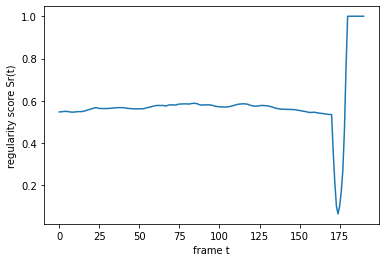

In [11]:
pr, before_reconstuction = evaluate(reload_model=True)

AUC:  0.3816901408450704
EER:  0.6666666666666666
EER THRESHOLD:  0.5655589705836856
Optimal threshold value is: 0.7586629376910422


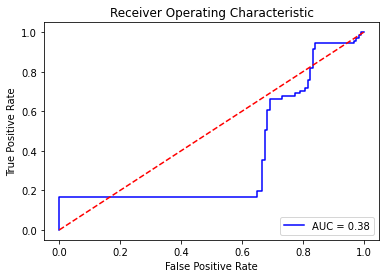

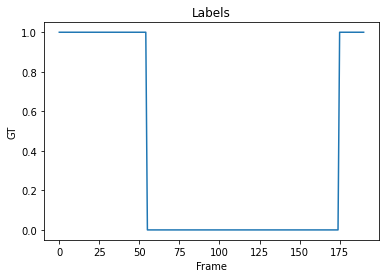

(0.3816901408450704, 0.6666666666666666)

In [12]:
from sklearn import metrics

def plotROC(pr):
  y_pred = pr
  y_test = [1 for element in range(0, 200)]

  for i in TestVideoFile[Config.SINGLE_TEST_VIDEO_FILE]:
    y_test[i] = 0

  #wariant 1 
  # y_test = y_test[9:]
  #wariant 2
  #y_test = y_test[:191]
  #wariant 3
  y_test = y_test[5:196]

  fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
  fnr = 1 - tpr
  auc = metrics.roc_auc_score(y_test, y_pred)

  eer_threshold = thresholds[np.nanargmin(np.absolute((fnr - fpr)))]
  eer = fpr[np.nanargmin(np.absolute((fnr - fpr)))]

  optimal = np.argmax(tpr - fpr)
  optimal_threshold = thresholds[optimal]


  #print("FPR: ", fpr)
  #print("TPR: ", tpr)
  #print("THRESHOLDS", thresholds)
  print("AUC: ", auc)
  print("EER: ", eer)
  print("EER THRESHOLD: ", eer_threshold)
  print("Optimal threshold value is:", optimal_threshold)

  plt.title('Receiver Operating Characteristic')
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')  
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

  plt.plot(y_test)
  plt.title('Labels')
  plt.ylabel('GT')
  plt.xlabel('Frame')
  plt.show()

  return auc, eer

plotROC(pr)


PATH:  UCSD_v5/UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test001
GT:  1
got model
(200, 227, 227, 1)
got data


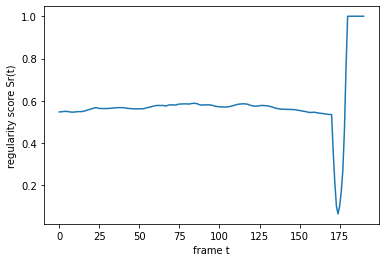

AUC:  0.3816901408450704
EER:  0.6666666666666666
EER THRESHOLD:  0.5655589705836856
Optimal threshold value is: 0.7586629376910422


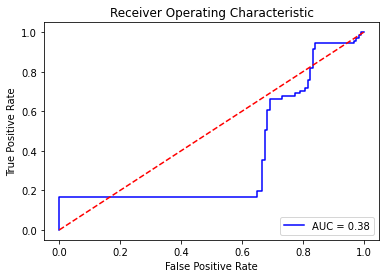

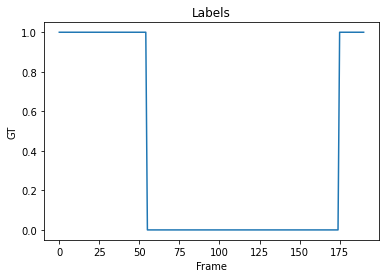

PATH:  UCSD_v5/UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test002
GT:  2
got model
(200, 227, 227, 1)
got data


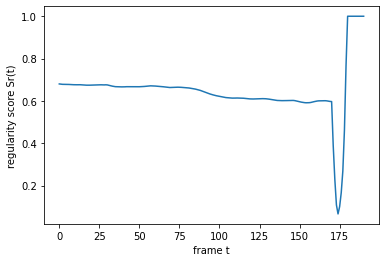

AUC:  0.9630121816168328
EER:  0.0
EER THRESHOLD:  0.6498220240647589
Optimal threshold value is: 0.6498220240647589


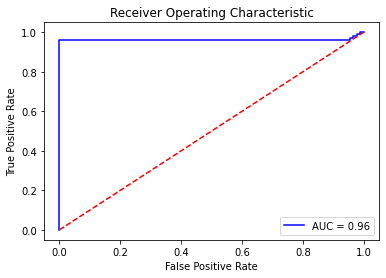

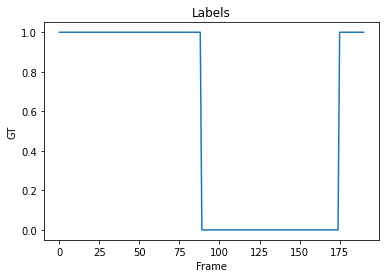

PATH:  UCSD_v5/UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test003
GT:  3
got model
(200, 227, 227, 1)
got data


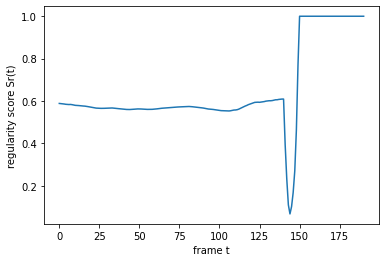

AUC:  0.84
EER:  0.0
EER THRESHOLD:  0.7673105737875623
Optimal threshold value is: 0.7673105737875623


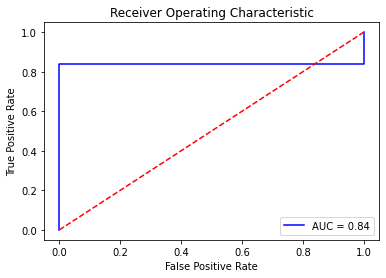

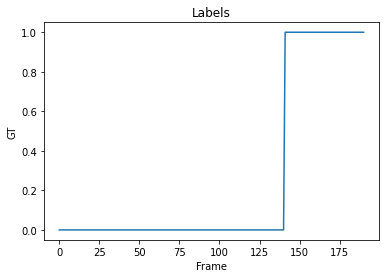

PATH:  UCSD_v5/UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test004
GT:  4
got model
(200, 227, 227, 1)
got data


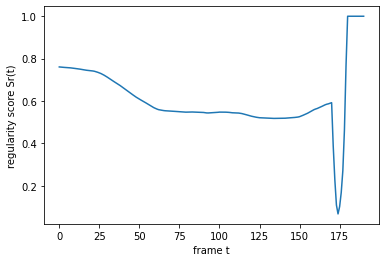

AUC:  0.9040650406504065
EER:  0.0
EER THRESHOLD:  0.7353821533920869
Optimal threshold value is: 0.7353821533920869


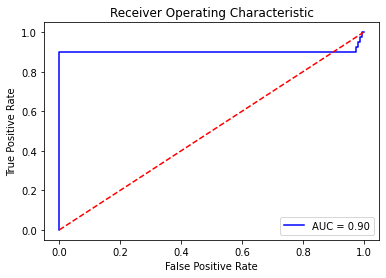

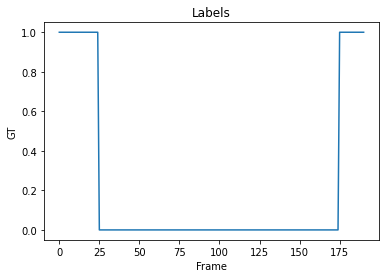

PATH:  UCSD_v5/UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test005
GT:  5
got model
(200, 227, 227, 1)
got data


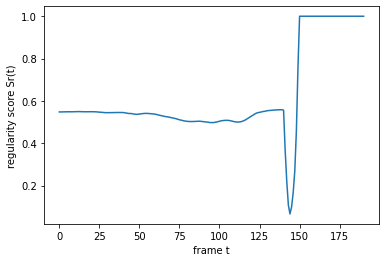

AUC:  0.8697640828117478
EER:  0.1935483870967742
EER THRESHOLD:  0.5477350540846566
Optimal threshold value is: 0.5496267138289466


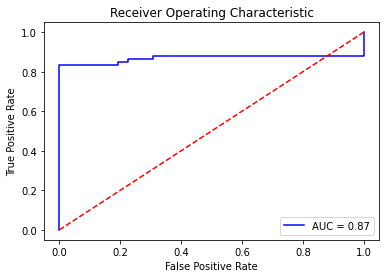

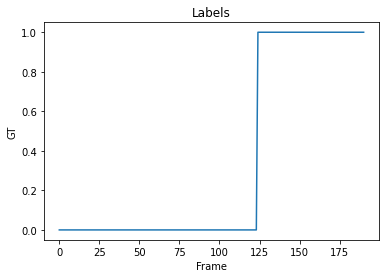

PATH:  UCSD_v5/UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test006
GT:  6
got model
(200, 227, 227, 1)
got data


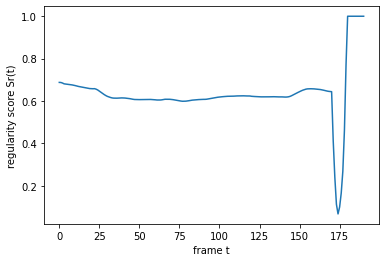

AUC:  0.7086697086697088
EER:  0.19480519480519481
EER THRESHOLD:  0.6440705833884373
Optimal threshold value is: 0.6440705833884373


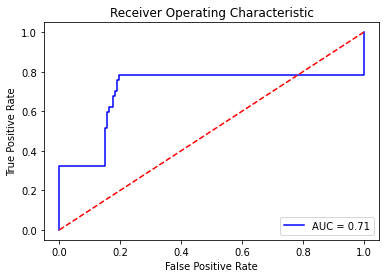

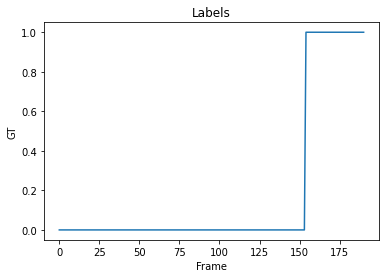

PATH:  UCSD_v5/UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test007
GT:  7
got model
(200, 227, 227, 1)
got data


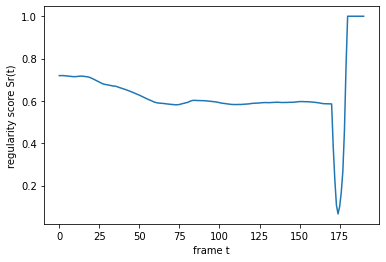

AUC:  0.9298941798941799
EER:  0.0
EER THRESHOLD:  0.6600388395296082
Optimal threshold value is: 0.6600388395296082


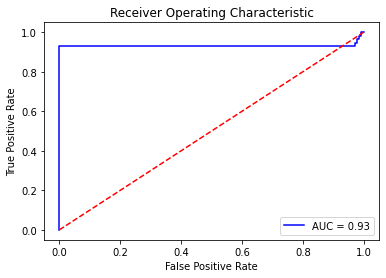

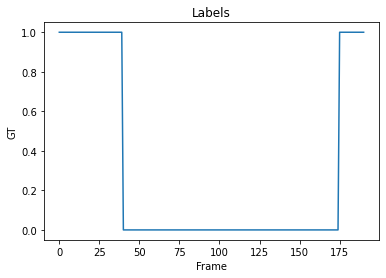

PATH:  UCSD_v5/UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test008
GT:  8
got model
(200, 227, 227, 1)
got data


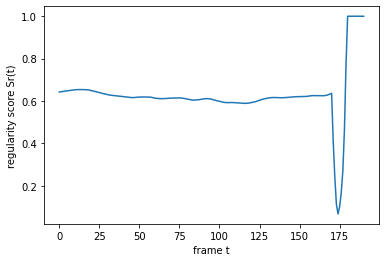

AUC:  0.7535714285714287
EER:  0.0
EER THRESHOLD:  0.7732696383985851
Optimal threshold value is: 0.7732696383985851


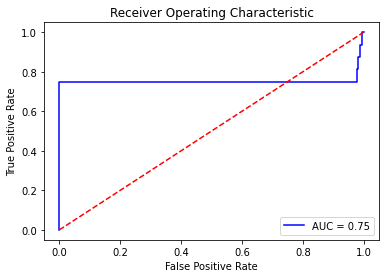

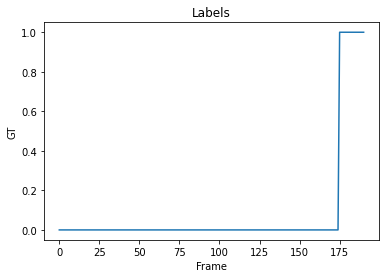

PATH:  UCSD_v5/UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test009
GT:  9
got model
(200, 227, 227, 1)
got data


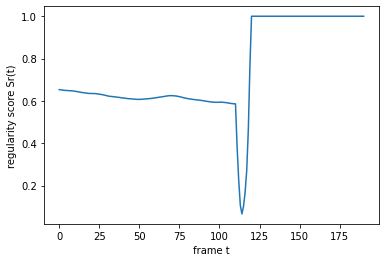

AUC:  0.9485125858123569
EER:  0.0
EER THRESHOLD:  0.7655611785100617
Optimal threshold value is: 0.7655611785100617


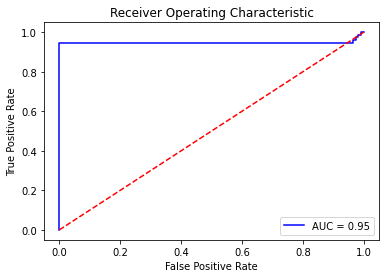

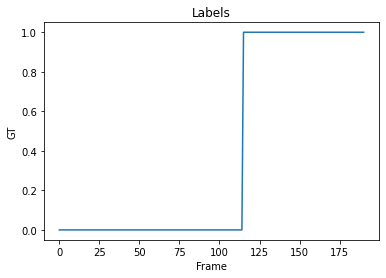

PATH:  UCSD_v5/UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test010
GT:  10
got model
(200, 227, 227, 1)
got data


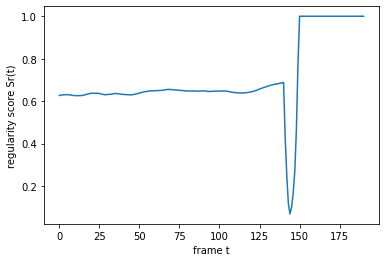

AUC:  0.9145427286356821
EER:  0.0
EER THRESHOLD:  0.7760347527335587
Optimal threshold value is: 0.7760347527335587


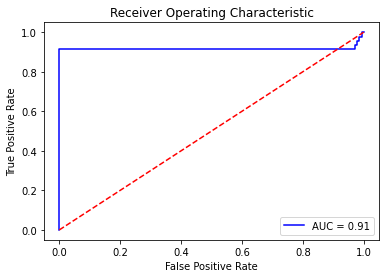

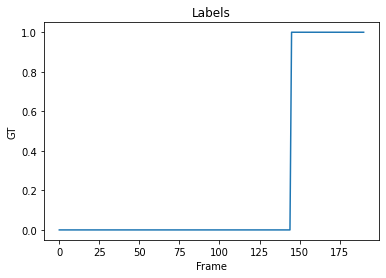

PATH:  UCSD_v5/UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test011
GT:  11
got model
(200, 227, 227, 1)
got data


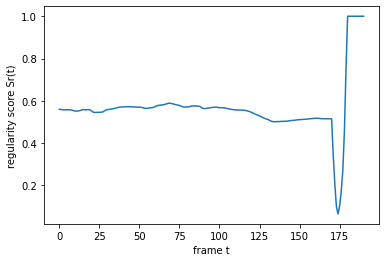

AUC:  0.7539285714285715
EER:  0.0
EER THRESHOLD:  0.7541923894767961
Optimal threshold value is: 0.7541923894767961


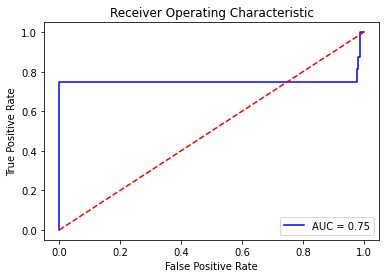

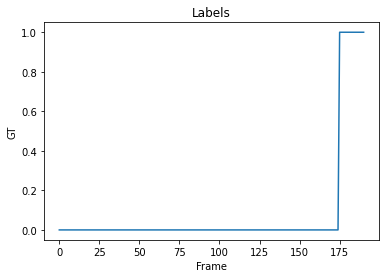

PATH:  UCSD_v5/UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test012
GT:  12
got model
(200, 227, 227, 1)
got data


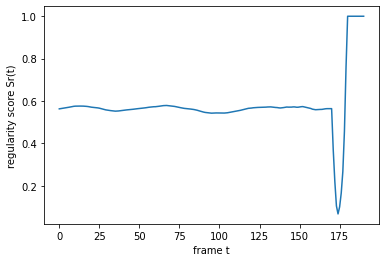

AUC:  0.706934386657889
EER:  0.3978494623655914
EER THRESHOLD:  0.565972139351275
Optimal threshold value is: 0.5720078621181737


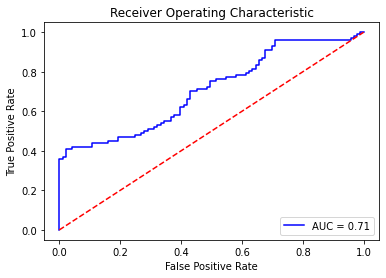

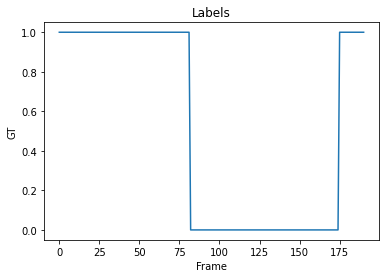

AUC:  0.806215419632823
EER:  0.12107247591118557


In [13]:
from os import listdir
from os.path import isfile, join, isdir


clips = []
# loop over the training folders (Train000,Train001,..)
for f in sorted(listdir(Config.TEST_PATH)):
    if isdir(join(Config.TEST_PATH, f)):
      if not 'gt' in f:
        clips.append(join(Config.TEST_PATH, f))


scores = []

for i in range(len(clips)):
  #if(i == 4 or i == 5 or i==34 or i == 16): #skip clip 17
  #if(i == 16): #skip clip 17
  #  continue

  Config.SINGLE_TEST_PATH = clips[i]
  Config.SINGLE_TEST_VIDEO_FILE = i+1

  print("PATH: ", Config.SINGLE_TEST_PATH)
  print("GT: ", Config.SINGLE_TEST_VIDEO_FILE)

  pr, before_reconstuction = evaluate()
  scores.append(plotROC(pr))


mean = np.mean(scores, axis=0)
#print(scores)
print("AUC: ", mean[0])
print("EER: ", mean[1])